In [1]:
import pixelator
import anndata

import os
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator import simple_aggregate

import scanpy as sc


In [2]:
from pathlib import Path
import pixelator
from pixelator import simple_aggregate


DATA_DIR = Path('./datasets')


FILENAMES = [
    "Sample05_V2_PBMC_r1.layout.dataset.pxl",
    "Sample06_V2_PBMC_r2.layout.dataset.pxl",
    "Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl",
    "Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl",
]

SAMPLE_NAMES = [
    "resting_r1", 
    "resting_r2",
    "stimulated_r1", 
    "stimulated_r2",
]

# COMBINED_FILENAME = "combined_resting_data.pxl"

COMBINED_FILENAME = "combined_resting_PHA_data.pxl"
COMBINED_PROCESSED_NAME = "combined_resting_PHA_data_PROCESSED.pxl"

combined_path = DATA_DIR / COMBINED_FILENAME
if os.path.exists(combined_path):
    pg_data = pixelator.read(combined_path)
else:
    
    baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
    for filename in FILENAMES:
        !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/{filename}"

    datasets = [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
    pg_data = pixelator.simple_aggregate(
        SAMPLE_NAMES, datasets
    )
    pg_data.save(combined_path, force_overwrite=True)


In [56]:
adata = pg_data.adata
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='antibodies')
adata.layers['counts'] = adata.X.copy()
adata.obs

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


pixels  a_pixels  b_pixels  antibodies  \
component                                                             
RCVCMP0000000_resting_r1       5833      3749      2084          79   
RCVCMP0000001_resting_r1       4769      3338      1431          79   
RCVCMP0000002_resting_r1       4227      2724      1503          78   
RCVCMP0000004_resting_r1       3285      2159      1126          79   
RCVCMP0000005_resting_r1       9958      6413      3545          79   
...                             ...       ...       ...         ...   
RCVCMP0002681_stimulated_r2    1184       784       400          78   
RCVCMP0002919_stimulated_r2     514       285       229          71   
RCVCMP0004154_stimulated_r2     223       156        67          65   
RCVCMP0005995_stimulated_r2    3162      2066      1096          76   
RCVCMP0008157_stimulated_r2     213       128        85          64   

                             molecules   reads  mean_reads_per_molecule  \
component                                                                 
RCVCMP0000000_resting_r1         35040  114108                 3.256507   
RCVCMP0000001_resting_r1         33399  107689                 3.224318   
RCVCMP0000002_resting_r1         34376  113349                 3.297330   
RCVCMP0000004_resting_r1         13859   42368                 3.057075   
RCVCMP0000005_resting_r1         43839  136302                 3.109149   
...                                ...     ...                      ...   
RCVCMP0002681_stimulated_r2       2075    5459                 2.630843   
RCVCMP0002919_stimulated_r2       1186    3194                 2.693086   
RCVCMP0004154_stimulated_r2        390    1058                 2.712821   
RCVCMP0005995_stimulated_r2       9274   24637                 2.656567   
RCVCMP0008157_stimulated_r2        616    1725                 2.800325   

                             median_reads_per_molecule  \
component                                                
RCVCMP0000000_resting_r1                           3.0   
RCVCMP0000001_resting_r1                           3.0   
RCVCMP0000002_resting_r1                           3.0   
RCVCMP0000004_resting_r1                           3.0   
RCVCMP0000005_resting_r1                           3.0   
...                                                ...   
RCVCMP0002681_stimulated_r2                        2.0   
RCVCMP0002919_stimulated_r2                        2.0   
RCVCMP0004154_stimulated_r2                        2.0   
RCVCMP0005995_stimulated_r2                        2.0   
RCVCMP0008157_stimulated_r2                        2.0   

                             mean_b_pixels_per_a_pixel  \
component                                                
RCVCMP0000000_resting_r1                      2.794345   
RCVCMP0000001_resting_r1                      2.933493   
RCVCMP0000002_resting_r1                      3.825624   
RCVCMP0000004_resting_r1                      2.352478   
RCVCMP0000005_resting_r1                      2.397318   
...                                                ...   
RCVCMP0002681_stimulated_r2                   1.709184   
RCVCMP0002919_stimulated_r2                   2.273684   
RCVCMP0004154_stimulated_r2                   1.608974   
RCVCMP0005995_stimulated_r2                   2.305905   
RCVCMP0008157_stimulated_r2                   2.015625   

                             median_b_pixels_per_a_pixel  ...  \
component                                                 ...   
RCVCMP0000000_resting_r1                             2.0  ...   
RCVCMP0000001_resting_r1                             2.0  ...   
RCVCMP0000002_resting_r1                             3.0  ...   
RCVCMP0000004_resting_r1                             2.0  ...   
RCVCMP0000005_resting_r1                             2.0  ...   
...                                                  ...  ...   
RCVCMP0002681_stimulated_r2                          1.0  ...   
RCVCMP0002919_stimulated_r2       

## Abundance EDA

Each sample has roughly 1000 cells screened for 84 antibodies.

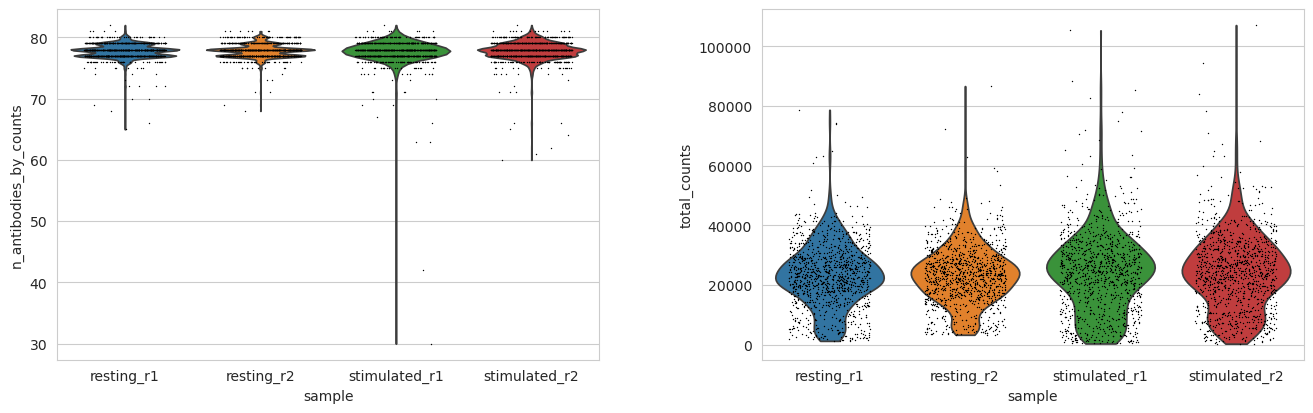

In [57]:
sc.pl.violin(
    adata,
    ["n_antibodies_by_counts", "total_counts",],
    groupby='sample',
    jitter=0.3,
    multi_panel=True,
)

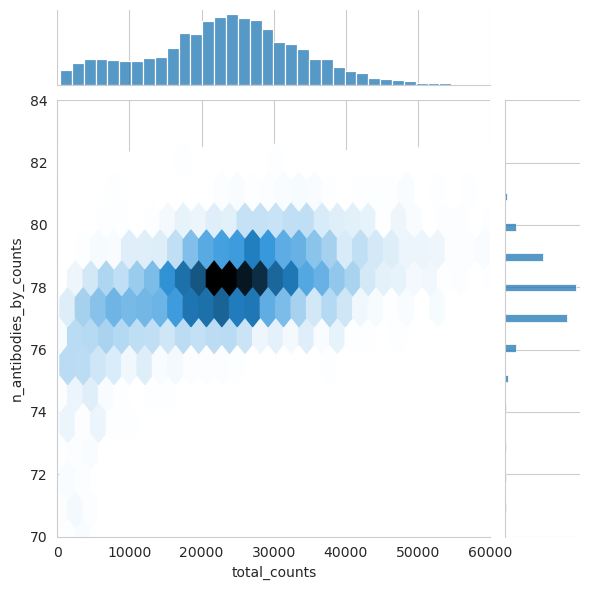

In [58]:
ax = sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_antibodies_by_counts",
    kind="hex",
    xlim=(0, 60*1000),
    ylim=(70, 84)
)

## Filtering data according to abundance "elbow point" and PixelGen Tau specificity
Low or high tau indicates the component is not a cell (antibody aggregate or other debris)

/tmp/ipykernel_3576586/144373203.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/pixelator/plot/__init__.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


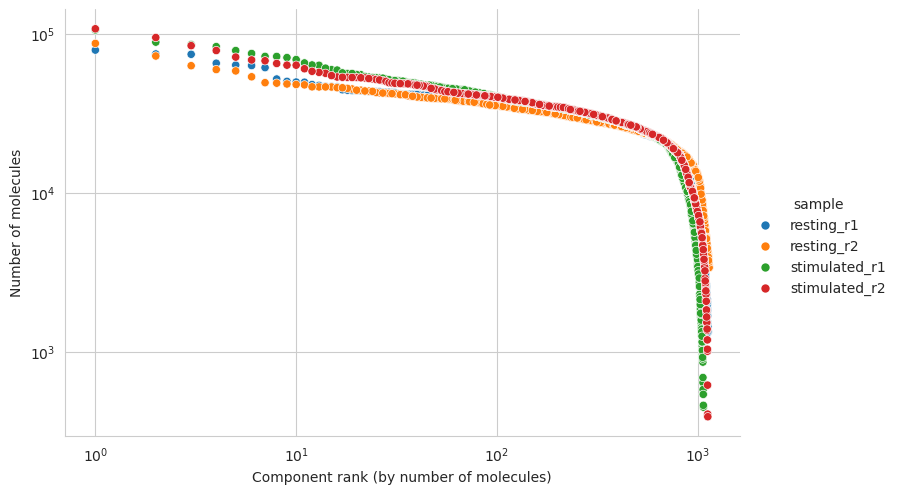

In [59]:
molecule_rank_df = adata.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")

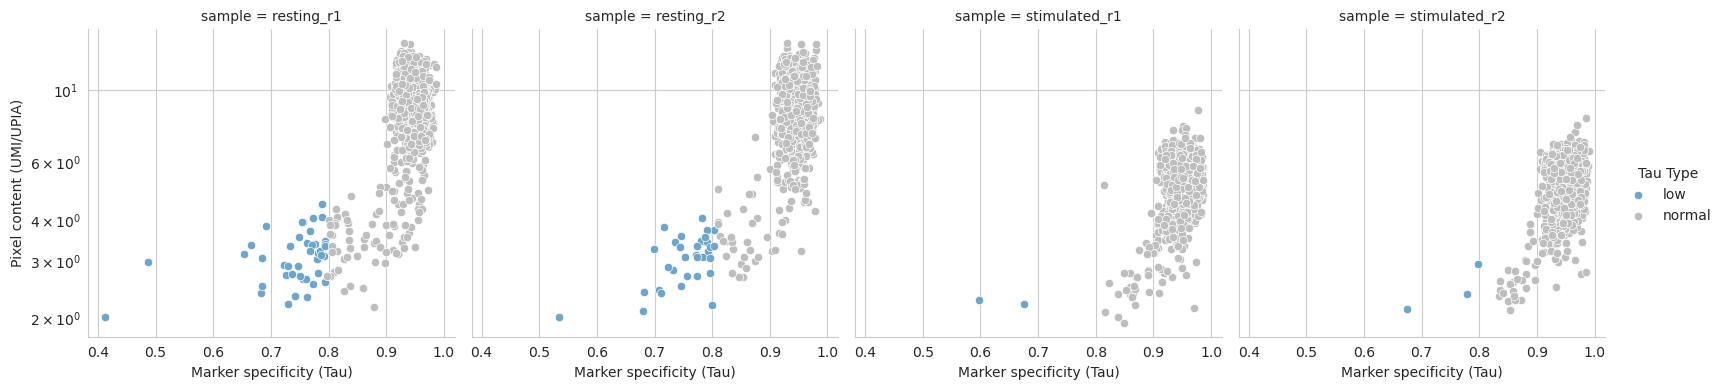

In [60]:
tau_metrics_df = adata.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

## Antibody variance increases with mean, most antibodies are present in all cells

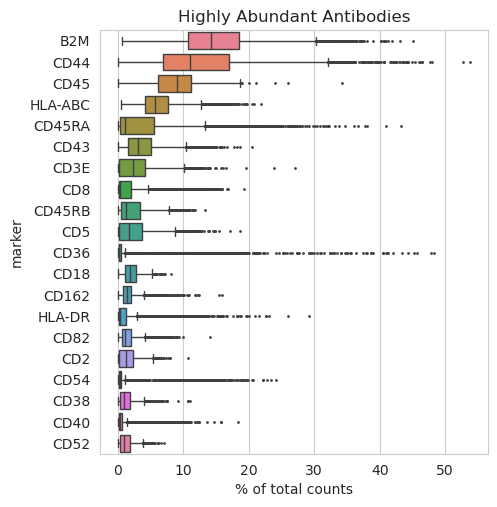

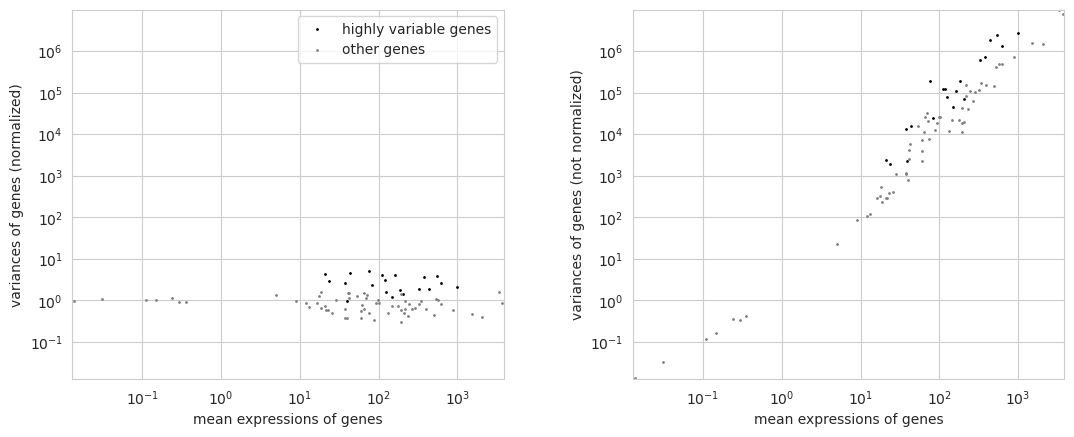

In [61]:
# assert adata.X[0,0] == adata.layers['counts'][0,0]
ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
ax.set_title('Highly Abundant Antibodies')
var_genes = sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=20, batch_key='sample', layer='counts', inplace=False)
sc.pl.highly_variable_genes(var_genes, show=True, log=True)

In [62]:
import itertools

counts_df = adata.to_df()
n_total_cells = counts_df.shape[0]
n_antibodies = counts_df.shape[1]

stacked_df_w_sample = counts_df.transpose().stack().reset_index().rename(columns={0:'count'}).join(adata.obs['sample'], on='component', validate='m:1')
sample_size_df = pd.DataFrame({'sample': SAMPLE_NAMES, 'unfiltered_sample_size':[len(adata.obs[adata.obs['sample'] == name]) for name in SAMPLE_NAMES]}).set_index('sample')
counts_df = adata.to_df()
stacked_df_w_sample = counts_df.transpose().stack().reset_index().rename(columns={0:'count'}).join(adata.obs['sample'], on='component', validate='m:1')

adata.uns['counts_per_sample'] = {}
for sample in SAMPLE_NAMES:
    sample_stacked = stacked_df_w_sample[stacked_df_w_sample['sample'] == sample]
    sample_pivoted = pd.pivot_table(sample_stacked, index='component', columns='marker', values='count')
    adata.uns['counts_per_sample'][sample] = sample_pivoted

abundance_thresh = 10


threshed_stacked_df_w_sample = stacked_df_w_sample[stacked_df_w_sample['count'] > abundance_thresh]
n_components_df_w_sample = threshed_stacked_df_w_sample.groupby(['marker', 'sample'])['component'].count().reset_index()
n_components_df_w_sample = n_components_df_w_sample.join(sample_size_df, on='sample')

n_components_df_w_sample['Percent of Sample'] = n_components_df_w_sample['component']*100 / n_components_df_w_sample['unfiltered_sample_size']


antibody_pairs_names = list(itertools.combinations(adata.var_names, 2))
antibody_pairs_prod_samples = [(markers[0], markers[1], sample_name) for markers, sample_name in itertools.product(antibody_pairs_names, SAMPLE_NAMES)]
antibody_count_per_pair_per_sample = pd.DataFrame(index=pd.MultiIndex.from_tuples(antibody_pairs_prod_samples, names=['marker_1', 'marker_2', 'sample']), columns={'Cell Count': pd.Series(dtype=int), 'Percent of Sample': pd.Series(dtype=float)})
for sample in SAMPLE_NAMES:
    sample_count = adata.uns['counts_per_sample'][sample]
    for i, (ab_1, ab_2) in enumerate(antibody_pairs_names):
        index = (ab_1, ab_2, sample)
        antibody_count_per_pair_per_sample.at[index, 'Cell Count'] = cell_count = len(sample_count[(sample_count[ab_1] > abundance_thresh) & (sample_count[ab_2] > abundance_thresh)])
        antibody_count_per_pair_per_sample.at[index, 'Percent of Sample'] = 100*cell_count / sample_size_df.loc[sample, 'unfiltered_sample_size']


antibody_count_per_pair_per_sample = antibody_count_per_pair_per_sample.reset_index()


antibody_variation_df = adata.to_df().aggregate(['mean', 'std']).transpose()
antibody_variation_df['std/mean'] = antibody_variation_df['std'] / antibody_variation_df['mean']


/tmp/ipykernel_3576586/3141128191.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_components_df_w_sample = threshed_stacked_df_w_sample.groupby(['marker', 'sample'])['component'].count().reset_index()


Text(0.5, 1.0, '% of Cells Per Antibody Pairs (Abundance > 10)')

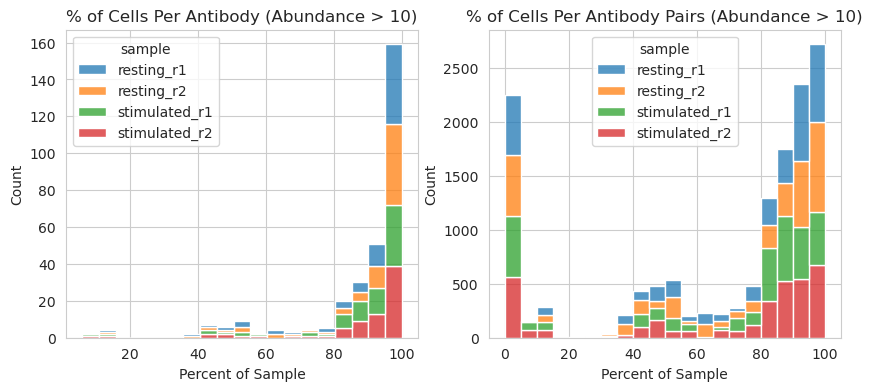

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(n_components_df_w_sample, x='Percent of Sample', ax=ax[0], binwidth=5, hue='sample', multiple='stack',)
ax[0].set_title(f'% of Cells Per Antibody (Abundance > {abundance_thresh})')

sns.histplot(antibody_count_per_pair_per_sample, x='Percent of Sample', ax=ax[1], binwidth=5, hue='sample', multiple='stack')
ax[1].set_title(f'% of Cells Per Antibody Pairs (Abundance > {abundance_thresh})')


In [64]:
# antibody_variation_df.sort_values(by='mean', axis=0, ascending=False, inplace=True)
antibody_variation_df[antibody_variation_df['mean'] < 10].index

Index(['CD123', 'CD180', 'CD191', 'CD192', 'CD24', 'CD335', 'CD39', 'CD58',
       'CD94'],
      dtype='object', name='marker')

In [66]:
components_to_keep = adata.obs[
    (adata.obs["molecules"] >= 10000)
    & (adata.obs["tau_type"] == "normal")
    & (adata.obs["tau"] > 0.9)
    & (adata.obs['a_pixels'] <= 10000)  # Removing outlier with 20K A pixels
].index

markers_to_keep = adata.var[
    adata.var['mean_counts'] >= 10
].index


orig_pg_data = pg_data
pg_data = orig_pg_data.filter(components=components_to_keep, markers=markers_to_keep)
adata = pg_data.adata
adata.layers['raw_filtered_counts'] = adata.X.copy()
adata.layers['counts'] = adata.X.copy()
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='antibodies')
# os.remove(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl")
# pg_data.save(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl", force_overwrite=True)

## DSB and CLR Normalization
DSB normalization should be taking care of "background noise" adding to the marker counts, due to non-specific binding.
However it does not work in all cases, it relies on having positive (=the marker should exist) and negative (=the marker should not exist) cell populations for each (?) marker.  
Q: Should we be normalizing for each sample separately, or together (currently together)?

In [67]:
from pixelator.analysis.normalization import dsb_normalize
from pixelator.statistics import clr_transformation

adata.layers['dsb'] = dsb_normalize(adata.to_df(), isotype_controls=["mIgG1", "mIgG2a", "mIgG2b"])
adata.layers['log1p'] = np.log1p(adata.to_df())
adata.layers['clr'] = clr_transformation(adata.to_df(), axis=1)


Text(0.5, 1.0, 'CLR')

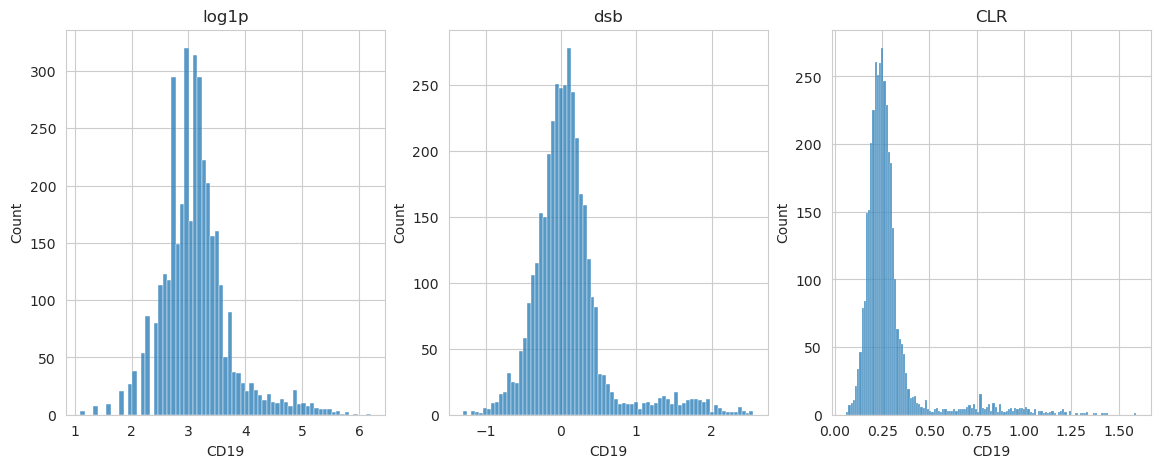

In [68]:
# CD19 marker
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.histplot(data=adata.to_df('log1p'), x='CD19', ax=axes[0])
axes[0].set_title('log1p')
sns.histplot(data=adata.to_df('dsb'), x='CD19', ax=axes[1])
axes[1].set_title('dsb')
sns.histplot(data=adata.to_df('clr'), x='CD19', ax=axes[2])
axes[2].set_title('CLR')

In [69]:
adata.X = adata.layers['clr'].copy()

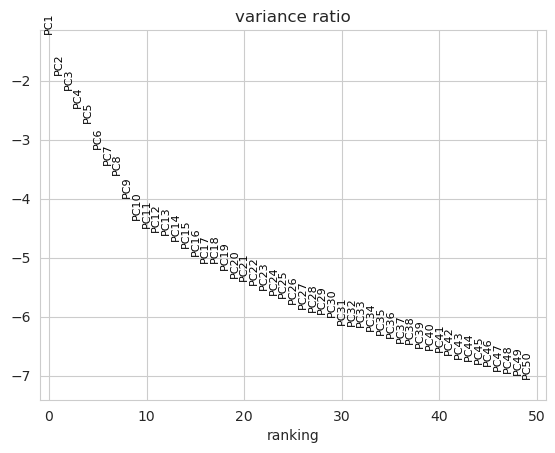

Text(0.5, 1.0, 'CD4 (T Helper)')

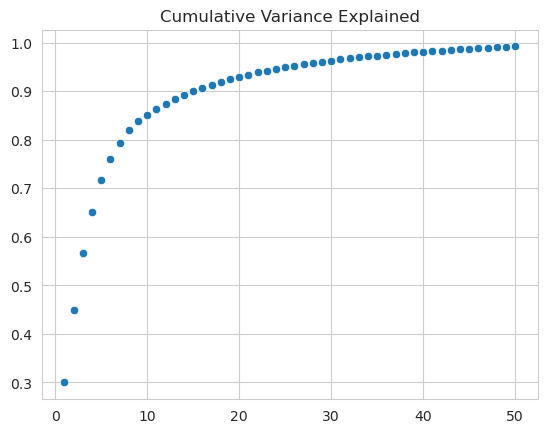

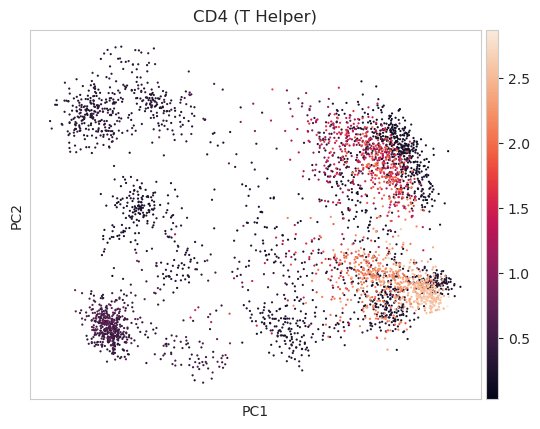

In [70]:
n_pcs = 50
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs, log=True)

fig, ax = plt.subplots(1)
var_ratio_accum = np.cumsum(adata.uns['pca']['variance_ratio'])
sns.scatterplot(x=list(range(1, n_pcs + 1)), y=var_ratio_accum, markers=[f'$PC{i}$' for i in range(1, n_pcs + 1)])
ax.set_title('Cumulative Variance Explained')
ax = sc.pl.pca(
    adata,
    color=["CD4",],
    dimensions=[(0, 1)],
    size=10,
    show=False
)
ax.set_title('CD4 (T Helper)')


## No significant batch effect, but stimulated vs non-stimulated are nicely separated

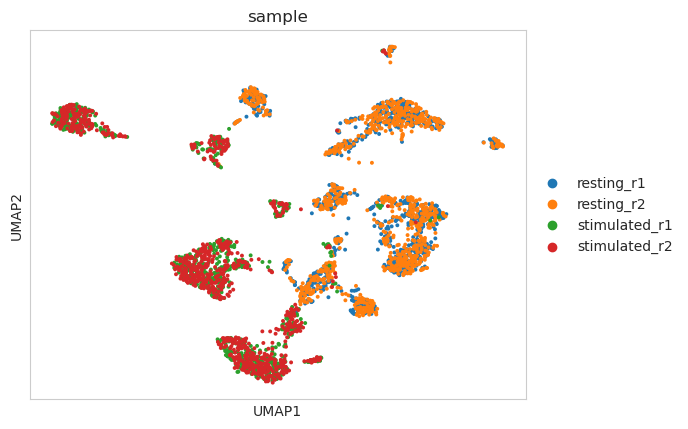

In [71]:
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample')

## Normalized count data nicely separates cell types

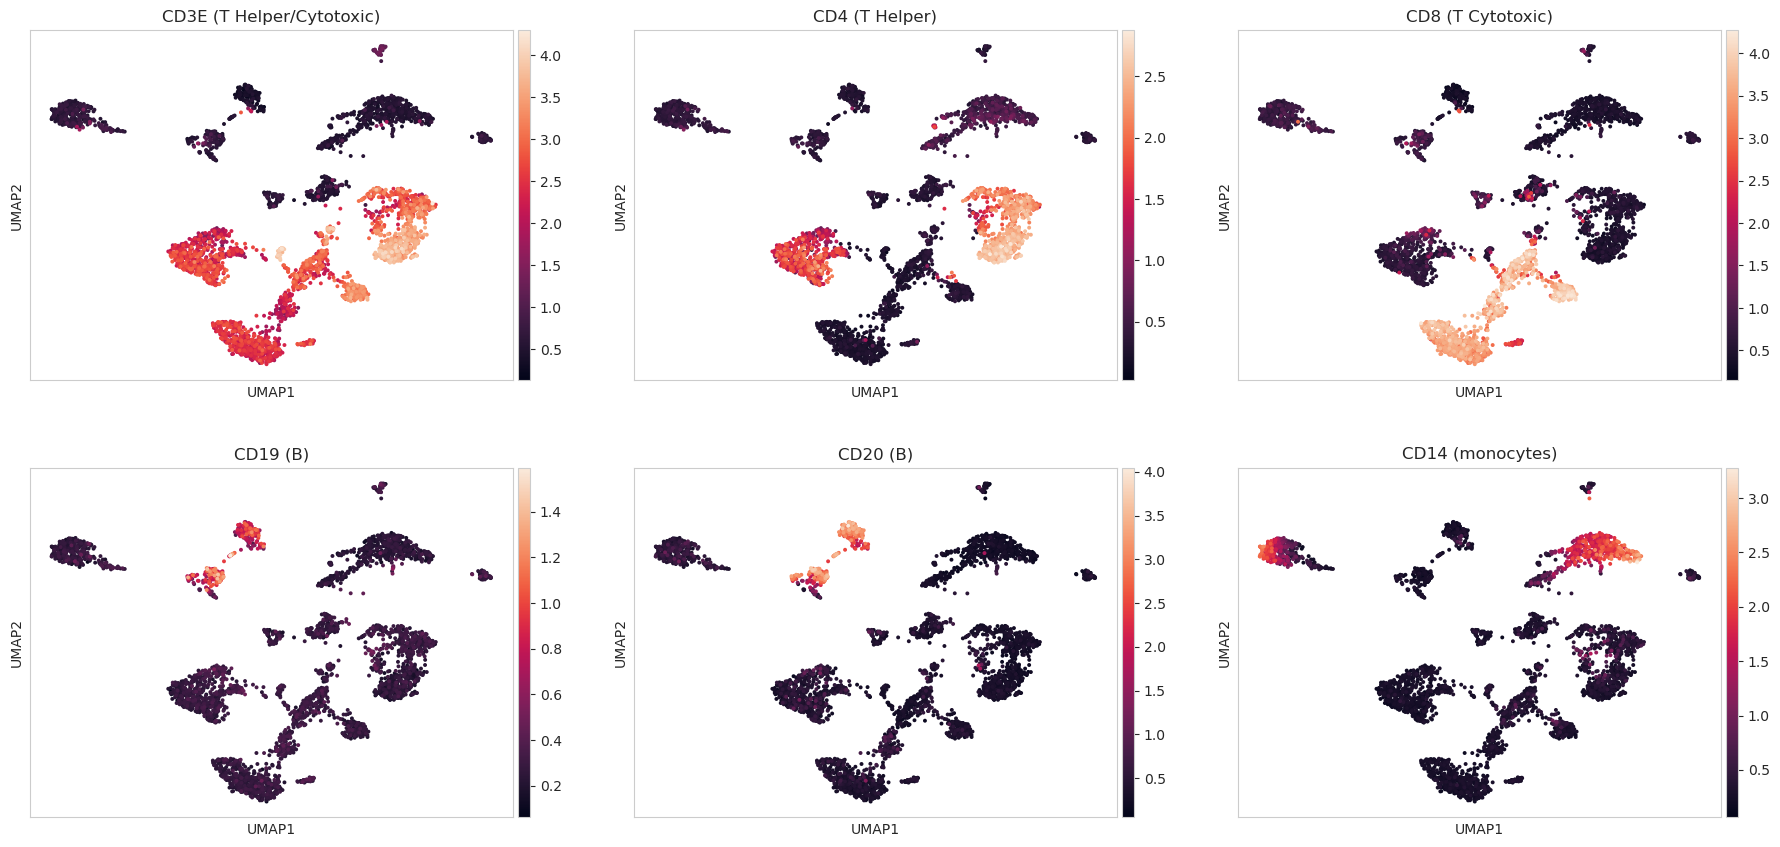

In [72]:
markers_of_interest = ["CD3E", "CD4", "CD8", "CD19", "CD20", "CD14"]
titles = ["CD3E (T Helper/Cytotoxic)", "CD4 (T Helper)", "CD8 (T Cytotoxic)", "CD19 (B)", "CD20 (B)", "CD14 (monocytes)"]
sc.pl.umap(adata, color=markers_of_interest, ncols=3, layer='clr', title=titles)

## No significant abundance imbalance across cell types

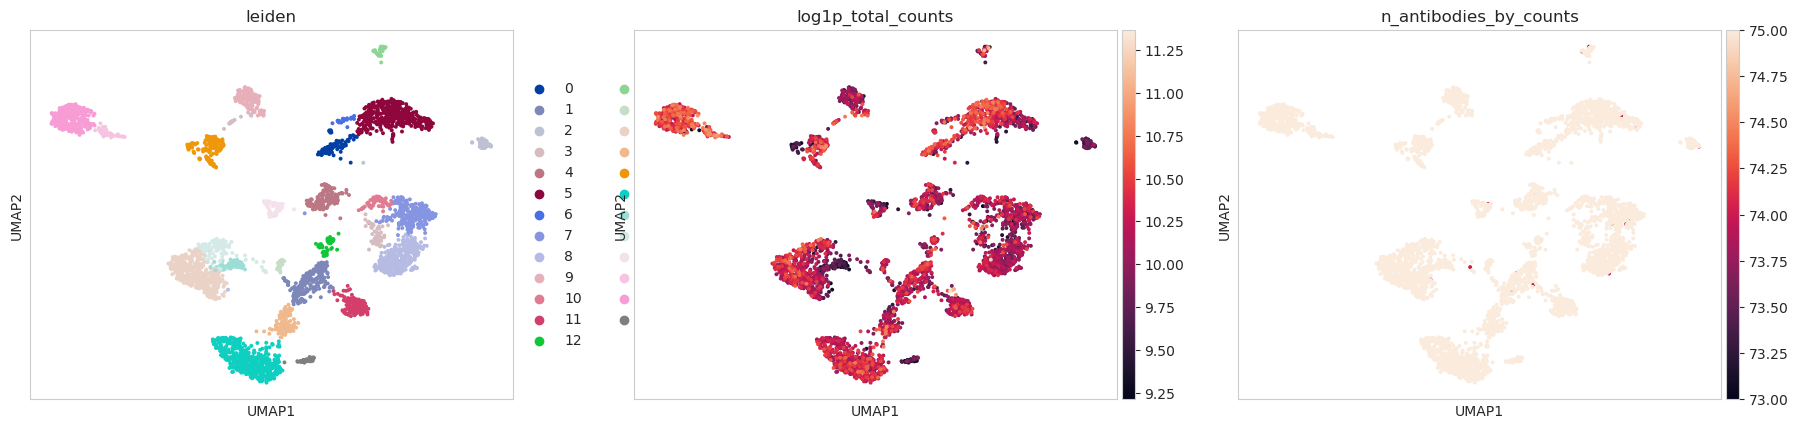

In [74]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=['leiden', 'log1p_total_counts', 'n_antibodies_by_counts'], ncols=3)

## Differential Abundance

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site

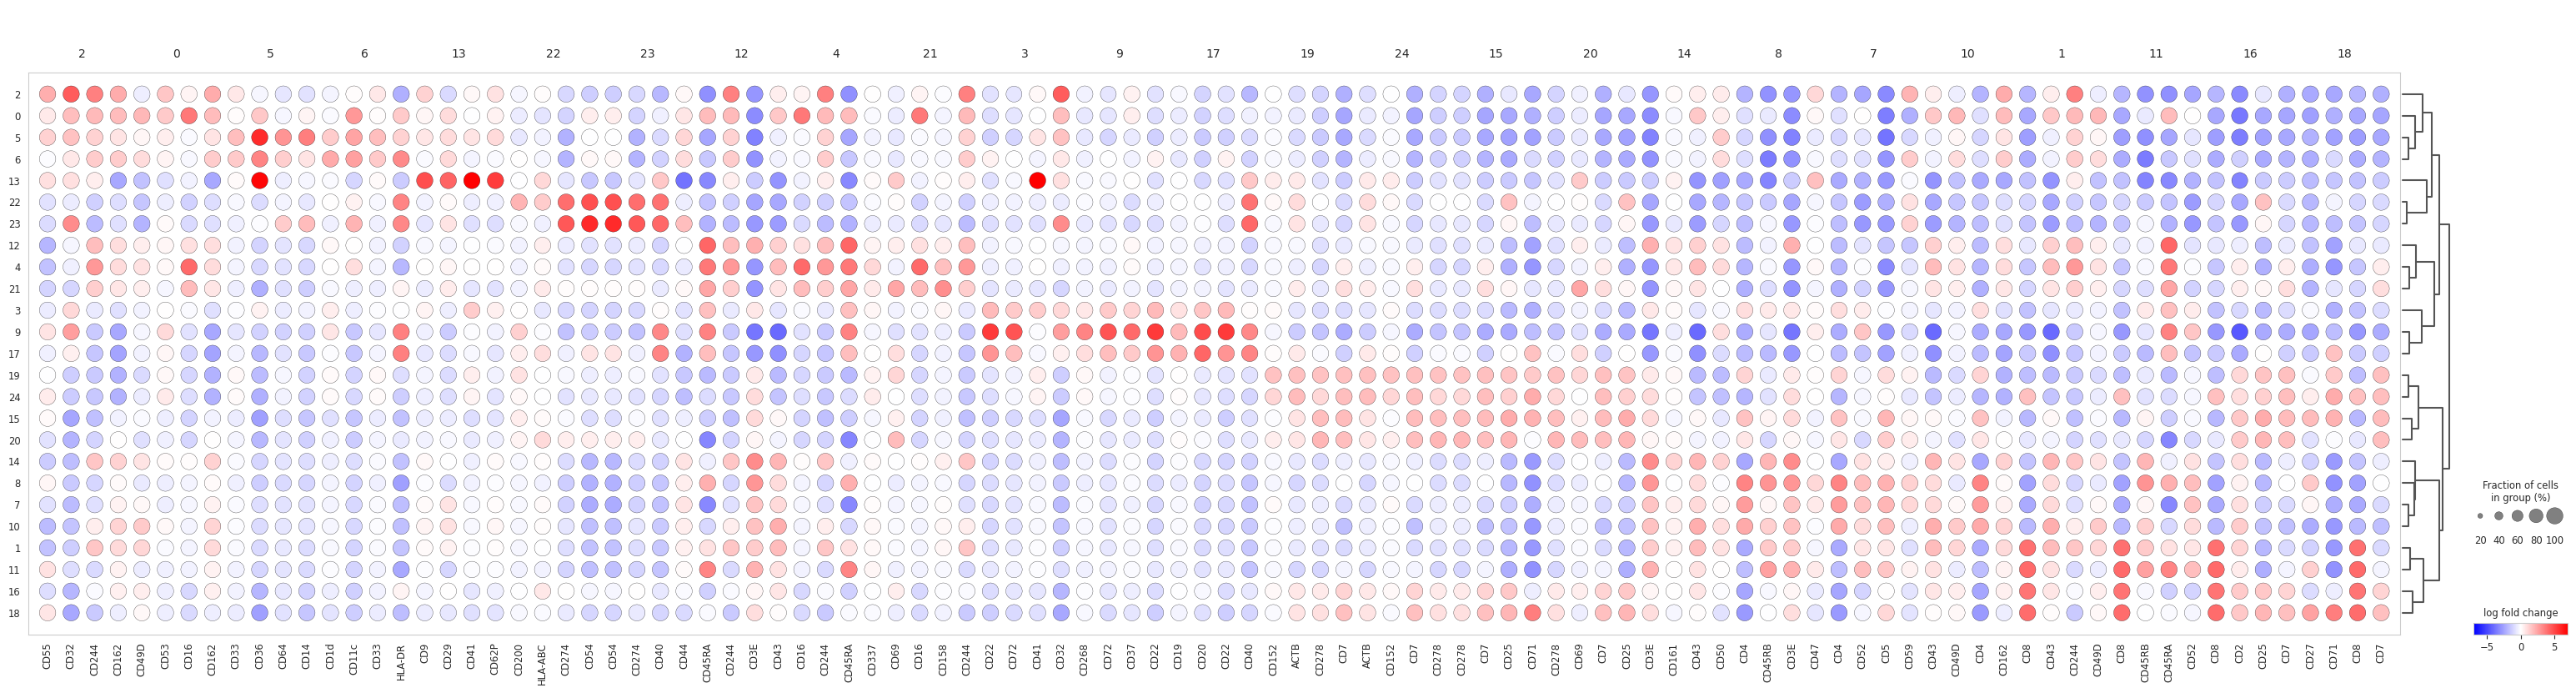

In [79]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot="logfoldchanges",
    min_logfoldchange=1,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    groupby="leiden",
)


In [7]:
adata.obs['sample_class'] = 'stimulated'
adata.obs['sample_class'] = adata.obs['sample_class'].where((adata.obs['sample'] == 'stimulated_r1') | (adata.obs['sample'] == 'stimulated_r2'), 'resting')

## Key takeaways
1. ~1000 cells per sample, most cells have 10K-40K antibodies sequenced
2. Most antibodies (out of 84) are present on all cells, with the most abundant accounting for a large chunk of the counts. Antibody pair distributions may be slightly more informative
3. There is no apparent batch effect and standard preprocessing allows to nicely view cell types.
4. 95% of variance is explained (PCA) with 20 PCs

In [8]:
# Uncomment to save

# pg_data.save(DATA_DIR / COMBINED_PROCESSED_NAME, force_overwrite=True)

Overwriting existing .pxl file at datasets/combined_resting_PHA_data_PROCESSED.pxl
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing write_elem from `anndata.experimental` is deprecated. Import anndata.io.write_elem instead.
  warnings.warn(msg, FutureWarning)


In [4]:
pg_data = pixelator.read(DATA_DIR / COMBINED_PROCESSED_NAME)
adata = pg_data.adata

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


## Graph Properties EDA

Reminder: each cell is a bipartite graph with left-side nodes being A pixels and right-side nodes being B pixels. Each edge between two pixels has a UMI that siginifies that that molecule was hybridized by both of those pixels, i.e. is in both of those small spatial areas.

Each cell has around 2000 A nodes and 1000 B nodes. Each A node has around 9 edges, to 3 distinct B nodes. Each B node is connected to around 6 distinct A nodes.

Each edge corresponds to a molecule, therefore # molecules = # edges which is centered around 20,000 as we saw in the Abundance EDA.

### Cells in different states have different properties
Namely, the stimulated cells have more pixels (local neighborhoods), less connectivity between pixels and less molecules per pixel

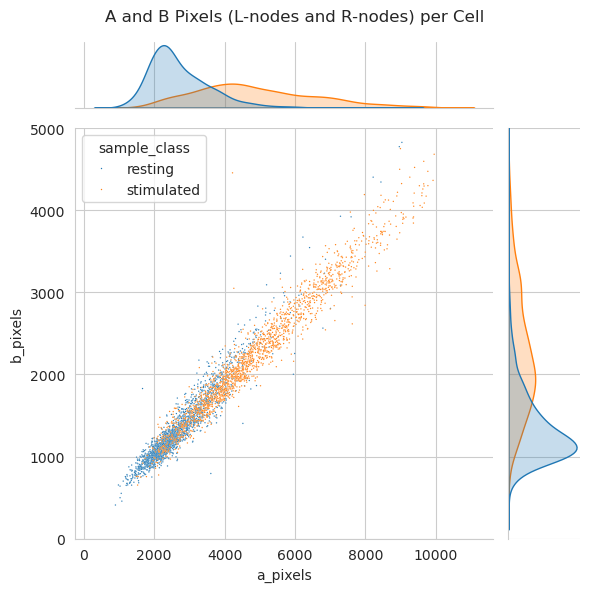

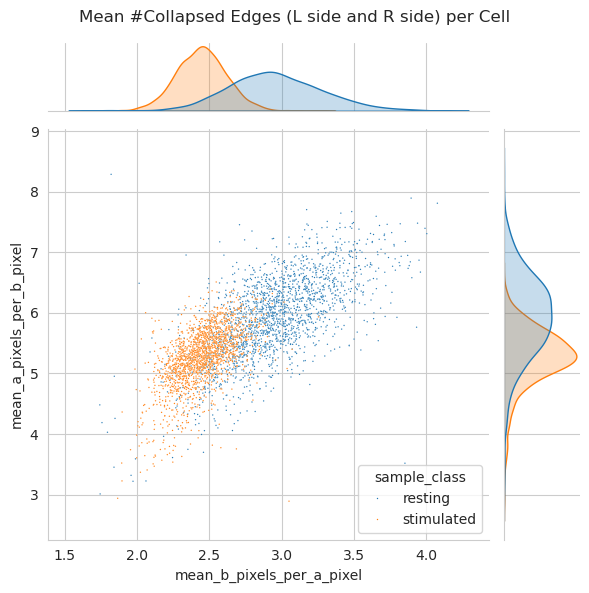

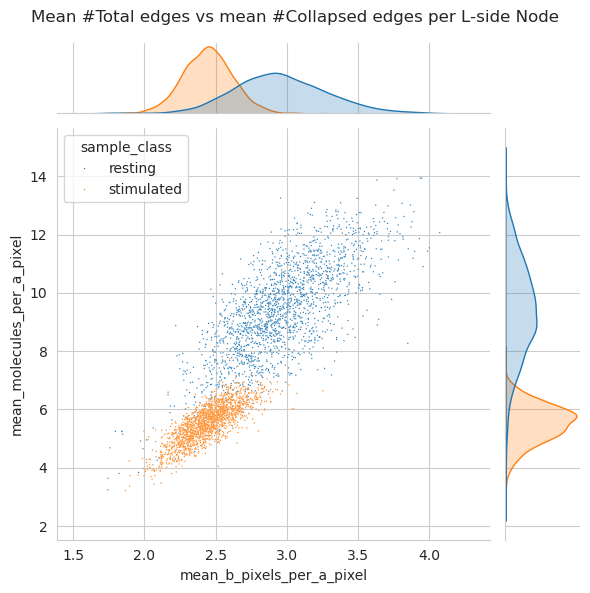

In [100]:
adata.obs['sample_class'] = 'stimulated'
adata.obs['sample_class'] = adata.obs['sample_class'].where((adata.obs['sample'] == 'stimulated_r1') | (adata.obs['sample'] == 'stimulated_r2'), 'resting')

jg  = sns.jointplot(adata.obs, x='a_pixels', y='b_pixels', kind='scatter', s=1, hue='sample_class', ylim=(0, 5000))
jg.figure.suptitle('A and B Pixels (L-nodes and R-nodes) per Cell')
jg.figure.tight_layout()

jg  = sns.jointplot(adata.obs, x='mean_b_pixels_per_a_pixel', y='mean_a_pixels_per_b_pixel', kind='scatter', s=1, hue='sample_class', color=sns.color_palette()[1])
jg.figure.suptitle('Mean #Collapsed Edges (L side and R side) per Cell')
jg.figure.tight_layout()

jg  = sns.jointplot(adata.obs, x='mean_b_pixels_per_a_pixel', y='mean_molecules_per_a_pixel', kind='scatter', s=1, hue='sample_class', color=sns.color_palette()[2])
jg.figure.suptitle('Mean #Total edges vs mean #Collapsed edges per L-side Node')
jg.figure.tight_layout()


## Colocalization and Polarization
The data comes with colocalization scores per pairs of markers per cell, calculated in two ways:
1. A Pearson's correlation between counts of the two markers in small areas, and a Z score calculated based on the r value
2. Jaccard index, which measures similarity between all neighborhoods containing each marker (And a Z score for Jaccard as well).
  
Generally Pearson's seems to suffer from a positive (colocalized) bias (example below), therefore we prefer Jaccard.  

Polarization data is calculated with Moran's I score for spatial autocorrelation, where the nodes are small neighborhoods (pixels) and the data for each node is the marker count.

### No big change in distributions after stimulation, however polarization has a positive bias

(-7.5, 7.5)

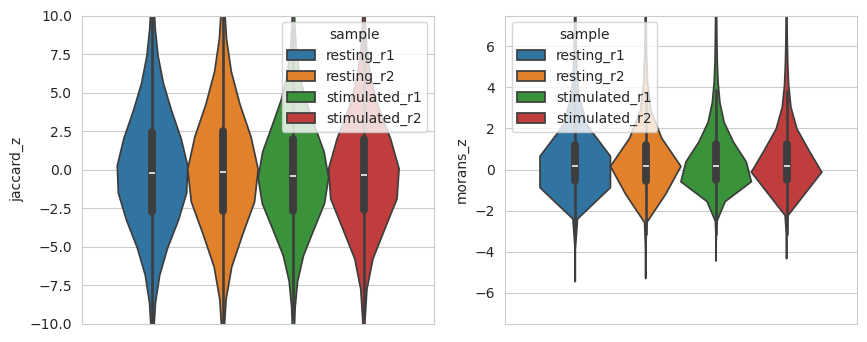

In [144]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.violinplot(pg_data.colocalization, y='jaccard_z', hue='sample', ax=ax[0])
ax[0].set_ylim(-10, 10)
sns.violinplot(pg_data.polarization, y='morans_z', hue='sample', ax=ax[1])
ax[1].set_ylim(-7.5,7.5)

### PHA Stimulation Analysis of Colocalization
PHA Stimulation amplifies colocalization/dispersion of pairs of antibodies.  
Of note, increases colocalization of (C44, C54) and (CD20, HLA-DR), increases dispersion of CD20 and HLA-DR from C44, CD8, CD7, CD27.  
CD7 and CD27 which were slightly dispersed become slightly colocalized.  
Important to remember that we're taking a mean, this could be more defined in specific cell groups.

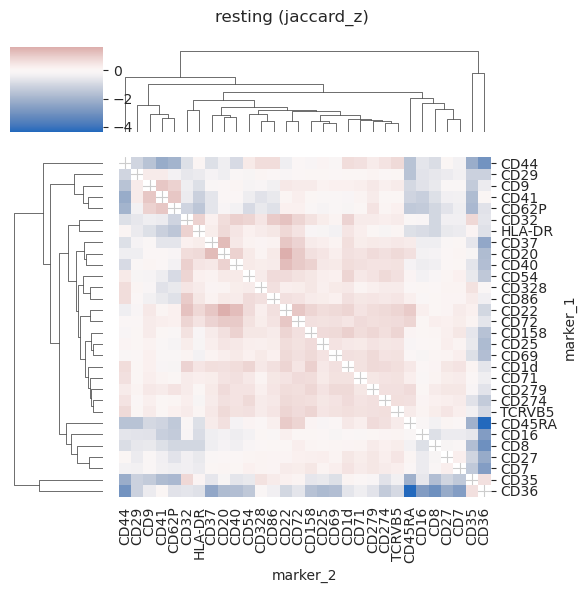

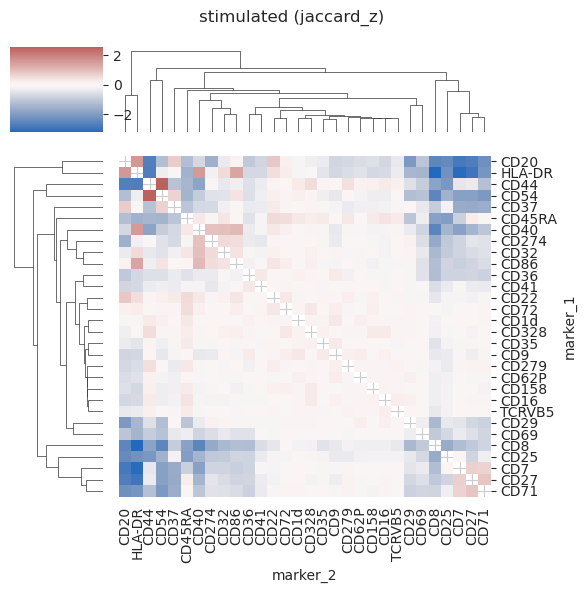

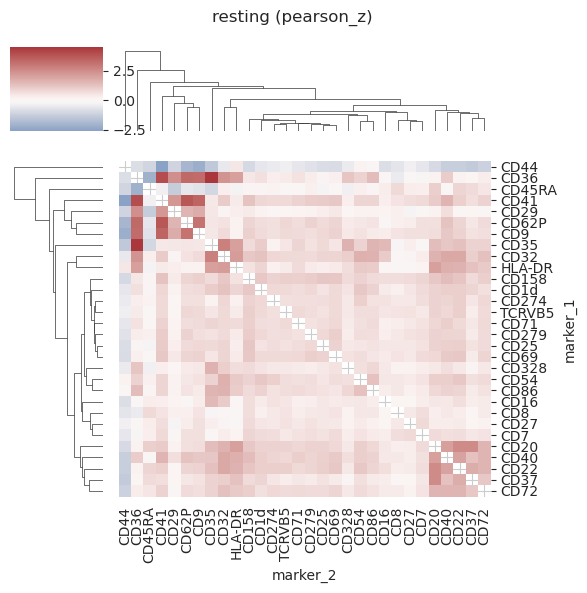

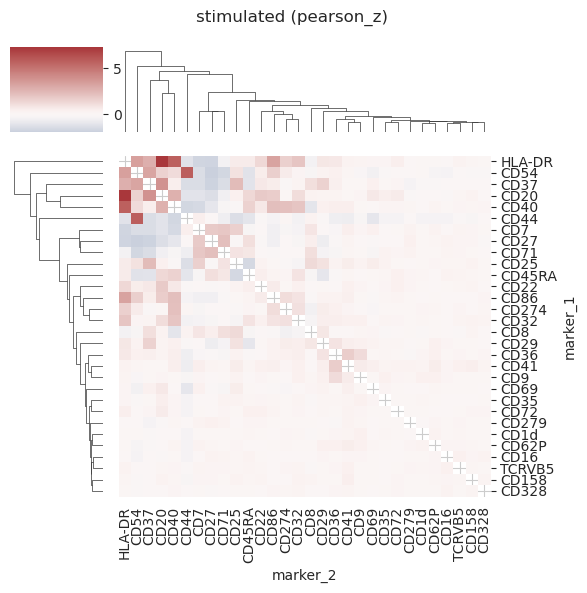

In [5]:
# Rank markers by variability
variable_markers = sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=30, flavor='seurat_v3', inplace=False)
highly_variable_marker_names = variable_markers[variable_markers['highly_variable']].index

coloc = pg_data.colocalization.copy()

# Make symmetric
coloc = pd.concat(
    [coloc,
     coloc.copy().rename(columns={'marker_1': 'marker_2', 'marker_2': 'marker_1'})],
     axis=0,
)

fake_auto_correlation = pd.DataFrame([
    {'marker_1': marker, 'marker_2': marker, 'pearson_z': 1, 'jaccard_z': 1, 'sample': sample} for marker in highly_variable_marker_names for sample in SAMPLE_NAMES
])

coloc = pd.concat(
    [coloc, fake_auto_correlation],
    axis=0
)

coloc = coloc.join(variable_markers['highly_variable'], on='marker_1', validate='many_to_one')
coloc.rename(columns={'highly_variable': 'marker_1_highly_variable'}, inplace=True)
coloc = coloc.join(variable_markers['highly_variable'], on='marker_2', validate='many_to_one')
coloc.rename(columns={'highly_variable': 'marker_2_highly_variable'}, inplace=True)
coloc['highly_variable_pair'] = coloc['marker_1_highly_variable'] & coloc['marker_2_highly_variable']

all_samples_filtered_coloc = coloc[coloc['highly_variable_pair']]
sample_classes = {'resting': ['resting_r1', 'resting_r2'], 'stimulated': ['stimulated_r1', 'stimulated_r2']}

for score in ('jaccard_z', 'pearson_z'):
    for sample_class, sample_names in sample_classes.items():
        filtered_coloc = all_samples_filtered_coloc[all_samples_filtered_coloc['sample'].isin(sample_names)]

        pivoted_coloc = pd.pivot_table(filtered_coloc, values=score, index='marker_1', columns='marker_2', aggfunc='mean')
        mask = pivoted_coloc == np.nan  # All False mask with shape of pivoted_coloc
        for marker in highly_variable_marker_names:
            mask.loc[marker, marker] = True
        clustergrid = sns.clustermap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), figsize=(6,6), xticklabels=True, yticklabels=True, mask=mask)
        clustergrid.figure.suptitle(f'{sample_class} ({score})')
        clustergrid.figure.tight_layout()




In [9]:
leiden_stats = adata.obs[['sample_class', 'leiden']].groupby('leiden')['sample_class'].value_counts().reset_index().groupby('leiden').agg({'count': ('min', 'max')})
leiden_majority = adata.obs[['sample_class', 'leiden']].groupby('leiden')['sample_class'].value_counts().reset_index().sort_values('count', ascending=False).groupby('leiden')['sample_class'].first()
leiden_stats.columns = leiden_stats.columns.to_flat_index()
leiden_stats.rename(columns={('count', 'min'): 'Minority Count', ('count', 'max'): 'Majority Count'}, inplace=True)
leiden_stats['Minority Ratio'] = leiden_stats['Minority Count'] / leiden_stats['Majority Count']
leiden_stats['Majority Sample'] = leiden_majority
leiden_stats.sort_values(by='Minority Ratio', ascending=False).head(5)

/tmp/ipykernel_1301512/2157210067.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leiden_stats = adata.obs[['sample_class', 'leiden']].groupby('leiden')['sample_class'].value_counts().reset_index().groupby('leiden').agg({'count': ('min', 'max')})
/tmp/ipykernel_1301512/2157210067.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leiden_stats = adata.obs[['sample_class', 'leiden']].groupby('leiden')['sample_class'].value_counts().reset_index().groupby('leiden').agg({'count': ('min', 'max')})
/tmp/ipykernel_1301512/2157210067.py:2: FutureWarning: The default of observed=False is deprecated and will be cha

Minority Count  Majority Count  Minority Ratio Majority Sample
leiden                                                                
12                  15              35        0.428571         resting
13                   7              27        0.259259         resting
10                   4              57        0.070175         resting
1                    8             206        0.038835         resting
17                   4             135        0.029630      stimulated

### PHA Stimulation Promotes Polarization 
Especially of CD54, CD44 (which were seen to colocalize), HLA-DR, CD20 (which were also seen to colocalize), and CD8.  
Interestingly group 3 seems to have special polarization for CD36, CD45RA, CD41, CD44 even before stimulation.

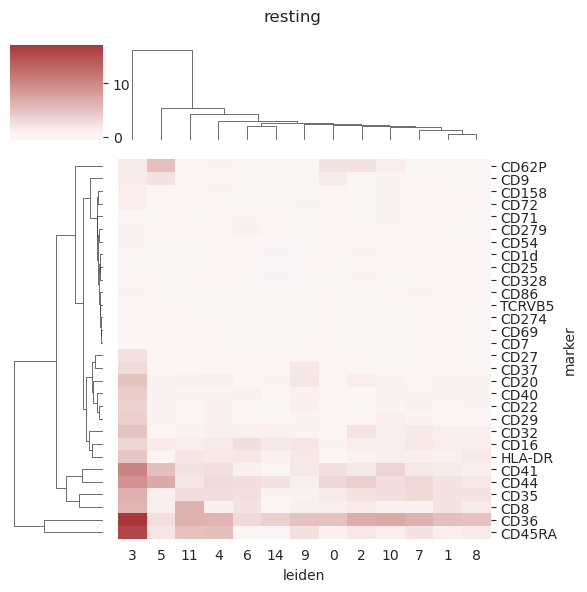

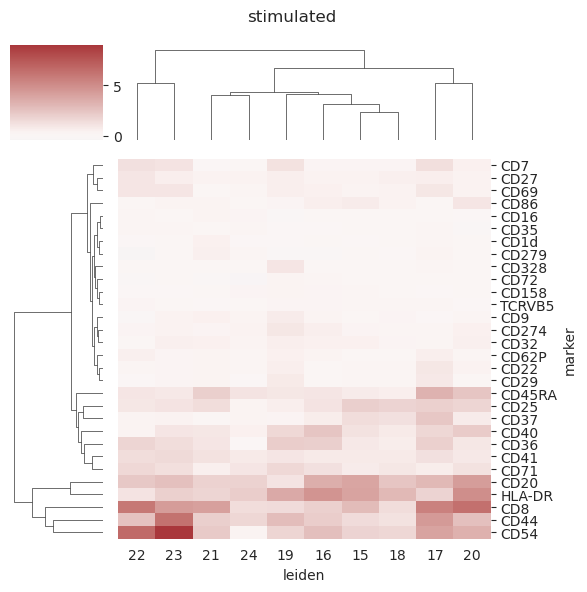

In [10]:
polarization = pg_data.polarization.copy().join(adata.obs['leiden'], on='component', validate='m:1').join(leiden_stats['Majority Sample'], on='leiden', validate='m:1')
polarization.rename(columns={'Majority Sample': 'Majority Sample Class in Leiden Group'}, inplace=True)
# Filter by highly variable markers and filter out bad leiden groups
all_samples_filtered_pol = polarization[(polarization['marker'].isin(highly_variable_marker_names)) & (~ polarization['leiden'].isin(('12','13')))]
for sample_class, sample_names in sample_classes.items():
    filtered_pol = all_samples_filtered_pol[(all_samples_filtered_pol['sample'].isin(sample_names)) & 
                                            (all_samples_filtered_pol['Majority Sample Class in Leiden Group'] == sample_class)]
    pivoted_pol = pd.pivot_table(filtered_pol, values='morans_z', index='marker', columns='leiden', aggfunc='mean', observed=False)
    clustergrid = sns.clustermap(pivoted_pol, center=0, cmap=sns.color_palette("vlag", as_cmap=True), figsize=(6,6), xticklabels=True, yticklabels=True)
    clustergrid.figure.suptitle(f'{sample_class}')
    clustergrid.figure.tight_layout() 

## Graph Layouts
Pxl software offers a way to visualize the graphs using some heuristic techniques.

In [103]:
# Visualize a component from group 3 with highest polarity for CD36
component = all_samples_filtered_pol[(all_samples_filtered_pol['leiden'] == '3') & (all_samples_filtered_pol['marker'] == 'CD36')].sort_values(by='morans_z', ascending=False).iloc[0]['component']

In [104]:
graph_layout_data = pg_data.precomputed_layouts.filter(component_ids=component).to_df()

In [105]:
import plotly.graph_objects as go
import plotly.io as pio
from plotly import subplots
import nbformat



pio.renderers.default = "plotly_mimetype+notebook_connected"

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data["x"],
            y=graph_layout_data["y"],
            z=graph_layout_data["z"],
            mode="markers",
            marker=dict(size=3, opacity=1, colorscale=["#cccccc", "#ff4500"]),
            marker_color=np.log1p(graph_layout_data["CD36"]),
        ),
    ]
)
# fig.update_layout(title=component)
fig_norm =  go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data["x_norm"],
            y=graph_layout_data["y_norm"],
            z=graph_layout_data["z_norm"],
            mode="markers",
            marker=dict(size=3, opacity=1, colorscale=["#cccccc", "#ff4500"]),
            marker_color=np.log1p(graph_layout_data["CD36"]),
        ),
    ]
)

fig

In [106]:
fig_norm

In [107]:
# Visualize a component from group with high coloc between CD44 and CD54
component_coloc = all_samples_filtered_coloc[(all_samples_filtered_coloc['marker_1'] == 'CD44') & (all_samples_filtered_coloc['marker_2'] == 'CD54')].sort_values(by='jaccard_z', ascending=False).iloc[0]['component']
graph_layout_data_coloc = pg_data.precomputed_layouts.filter(component_ids=component_coloc).to_df()

In [108]:
import colorsys

marker_1 = 'CD44'
marker_2 = 'CD54'


graph_layout_data_coloc['color'] = ['black' if (expr_1 > 0 and expr_2 > 0) else ('red' if expr_1 > 0 else ('blue' if expr_2 > 0 else 'gray')) for 
                                    (expr_1, expr_2) in zip(graph_layout_data_coloc[marker_1], graph_layout_data_coloc[marker_2])]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data_coloc["x_norm"],
            y=graph_layout_data_coloc["y_norm"],
            z=graph_layout_data_coloc["z_norm"],
            mode="markers",
            marker=dict(size=3, opacity=1),
            marker_color=graph_layout_data_coloc['color'],
        ),
    ]
)

fig

In [115]:
# Same but with a component from the resting data where CD44 and CD54 are less colocalized
marker_1 = 'CD44'
marker_2 = 'CD54'
marker_mask = (all_samples_filtered_coloc['marker_1'] == 'CD44') & (all_samples_filtered_coloc['marker_2'] == 'CD54')
min_jaccard = all_samples_filtered_coloc[marker_mask]['jaccard_z'].abs().min()
component_coloc_2 = all_samples_filtered_coloc[marker_mask & 
                                             (np.isclose(np.abs(all_samples_filtered_coloc['jaccard_z']), min_jaccard))].iloc[0]['component']
graph_layout_data_coloc_2 = pg_data.precomputed_layouts.filter(component_ids=component_coloc_2).to_df()




graph_layout_data_coloc_2['color'] = ['black' if (expr_1 > 0 and expr_2 > 0) else ('red' if expr_1 > 0 else ('blue' if expr_2 > 0 else 'gray')) for 
                                    (expr_1, expr_2) in zip(graph_layout_data_coloc_2[marker_1], graph_layout_data_coloc_2[marker_2])]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=graph_layout_data_coloc_2["x_norm"],
            y=graph_layout_data_coloc_2["y_norm"],
            z=graph_layout_data_coloc_2["z_norm"],
            mode="markers",
            marker=dict(size=3, opacity=1),
            marker_color=graph_layout_data_coloc_2['color'],
        ),
    ]
)

fig

In [109]:

# max_expr_1 = graph_layout_data_coloc[marker_1].quantile(q=0.9)
# max_expr_2 = graph_layout_data_coloc[marker_2].quantile(q=0.9)

# graph_layout_data_coloc['rel_expression_1'] = [min(expr_1 / max_expr_1, 1) for expr_1 in graph_layout_data_coloc[marker_1]]
# graph_layout_data_coloc['rel_expression_2'] = [min(expr_2 / max_expr_2, 1) for expr_2 in graph_layout_data_coloc[marker_2]]

# graph_layout_data_coloc['hue'] = [300 + 60*(rel_1 - rel_2) for (rel_1, rel_2) in zip(graph_layout_data_coloc['rel_expression_1'], graph_layout_data_coloc['rel_expression_2'])]
# graph_layout_data_coloc['saturation'] = [20+(80 / np.sqrt(2))*(np.sqrt(rel_1**2 + rel_2**2)) for (rel_1, rel_2) in zip(graph_layout_data_coloc['rel_expression_1'], graph_layout_data_coloc['rel_expression_2'])]
# # graph_layout_data_coloc['saturation'] = 100

# # graph_layout_data_coloc['joint_color'] = [f'rgba({255*expr_1 / max_expr_1}, 0, {255*expr_2 / max_expr_2}, 0.1)' for (expr_1, expr_2) in zip(graph_layout_data_coloc[marker_1], graph_layout_data_coloc[marker_2])]
# # graph_layout_data_coloc['hsva'] = [f'hsva({int(h)}, {int(s)}%, 100%, 1)' for (h,s) in zip(graph_layout_data_coloc['hue'], graph_layout_data_coloc['saturation'])]
# rgba = []
# for (h,s) in zip(graph_layout_data_coloc['hue'], graph_layout_data_coloc['saturation']):
#     col = colorsys.hsv_to_rgb(h=h,s=s/100,v=1)
#     rgba.append(f'rgba({255*col[0]},{255*col[1]},{255*col[2]},1)')

# graph_layout_data_coloc['rgba'] = rgba


In [110]:
    # fig, ax = plt.subplots(1, 4, figsize=(23, 5))
    # fig.suptitle(f'Colocalization between Highly Variable Antibodies - {sample_class}')
    
    # pivoted_coloc = pd.pivot_table(filtered_coloc, values='pearson_z', index='marker_1', columns='marker_2', aggfunc='mean')
    # sns.heatmap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[0])
    # # sns.clustermap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0])
    # ax[0].set_title("Pearson's r z score, mean across cells")
    # pivoted_coloc = pd.pivot_table(filtered_coloc, values='jaccard_z', index='marker_1', columns='marker_2', aggfunc='mean')
    # sns.heatmap(pivoted_coloc, center=0, cmap=sns.color_palette("vlag", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[1])
    # ax[1].set_title("Jaccard z score, mean across cells")

    # ax[0].grid(False)
    # ax[1].grid(False)
    # # pg_data_1.colocalization.groupby(['marker_1', 'marker_2']).aggregate('')

    # scores_corr = filtered_coloc.groupby(['marker_1', 'marker_2'])[['pearson_z', 'jaccard_z']].corr().iloc[0::2,-1].reset_index().drop(columns=['level_2']).rename(columns={'jaccard_z': 'Pearson-Jaccard Correlation'})
    # pivoted_corr = pd.pivot_table(scores_corr, values='Pearson-Jaccard Correlation', index='marker_1', columns='marker_2')
    # sns.heatmap(pivoted_corr, xticklabels=True, yticklabels=True, ax=ax[2], cmap=sns.light_palette("seagreen", as_cmap=True))
    # ax[2].grid(False)
    # ax[2].set_title('Pearson-Jaccard Correlation Across Cells')

    # pivoted_coloc = pd.pivot_table(filtered_coloc, values='component', index='marker_1', columns='marker_2', aggfunc='count')
    # sns.heatmap(pivoted_coloc, cmap=sns.light_palette("orange", as_cmap=True), xticklabels=True, yticklabels=True, ax=ax[3])
    # ax[3].grid(False)
    # ax[3].set_title("Cell Count Per Pair")